In [6]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

We define the function $f$:

In [7]:
def f(u):
    return np.cos(2 * np.pi * (np.mean(u) - 1/2))

Notice that $I := \int_{[0, 1]^d} f(u) du = \mathbb{E}_{U \sim \mathcal{U}([0, 1]^d)}[f(U)]$. Thus, we can approximate $I$ using Monte Carlo.

In [8]:
def montecarlo(d, N = 10000):
    X = [f(rd.random(d)) for _ in range(N)]
    return np.mean(X)

Here are the results for different values of `N`:

In [9]:
d_values = [1, 2, 3, 5, 10, 100]
N_values = [100, 1000, 10000]

data = {N: [montecarlo(d, N) for d in d_values] for N in N_values}

df = pd.DataFrame(data, index = d_values)
df.iloc[:len(d_values)]

,100,1000,10000
1,-0.143504,-0.001889,-0.003585
2,0.433093,0.408188,0.404777
3,0.658122,0.557396,0.564377
5,0.760872,0.712537,0.718261
10,0.839180,0.855814,0.846036
100,0.983766,0.982863,0.983686


For quasi-MC and for $d > 1$, like in the course slides, we need to generate the $u_n$'s so that so that exactly one point falls in each horizontal or vertical strip of $\left\{\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right\}^d$. For this we use the following function:

In [10]:
def generate_indices(d, N = 10000):
    list_indices = []
    X = []
    arr = np.array(list(range(N)))
    perm = [rd.permutation(arr) for _ in range(d- 1)]
    for i in range(N):
        indices = [i] + [perm[j][i] for j in range(d - 1)]
        list_indices.append(indices)
    list_indices = np.array(list_indices)
    list_indices = (2 * list_indices + 1)/(2 * N)
    return list_indices

Case $d = 2$: this is what `generate_indices(2, 10)` corresponds to:

[[0.05 0.15]
 [0.15 0.55]
 [0.25 0.75]
 [0.35 0.05]
 [0.45 0.25]
 [0.55 0.65]
 [0.65 0.95]
 [0.75 0.35]
 [0.85 0.85]
 [0.95 0.45]]


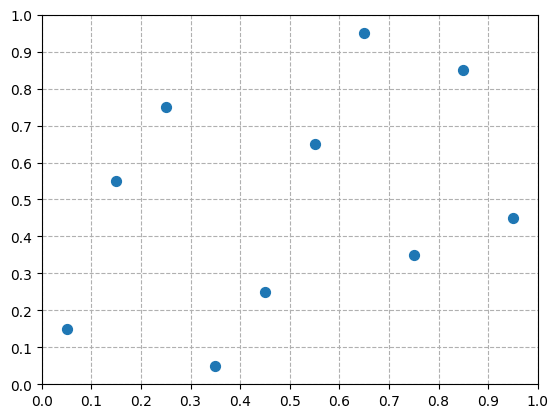

In [44]:
points = generate_indices(2, 10)

print(points)

x = points[:, 0]
y = points[:, 1]

plt.scatter(x, y, s = 50)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle = '--')
plt.show()

Case $d = 3$: this is what `generate_indices(3, 10)` corresponds to:

[[0.05 0.55 0.45]
 [0.15 0.75 0.35]
 [0.25 0.15 0.65]
 [0.35 0.65 0.75]
 [0.45 0.05 0.25]
 [0.55 0.45 0.15]
 [0.65 0.95 0.95]
 [0.75 0.25 0.05]
 [0.85 0.85 0.55]
 [0.95 0.35 0.85]]


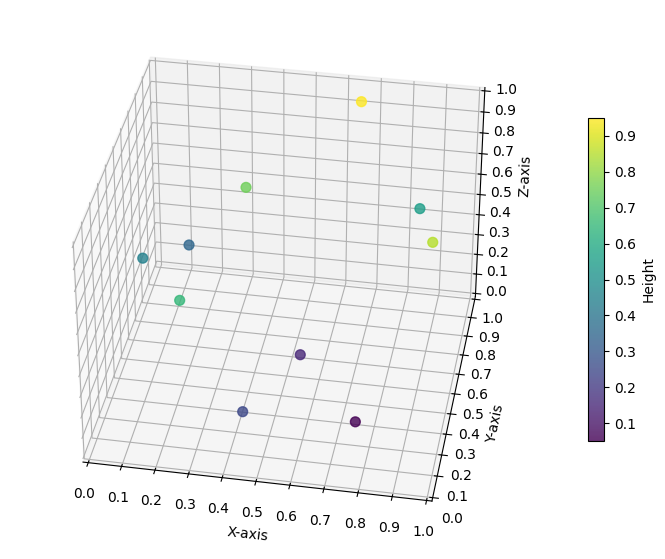

In [61]:
points = generate_indices(3, 10)

print(points)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

# Grid
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_zticks(np.linspace(0, 1, 11))
ax.grid(True, linestyle = '--')

# Point of view
ax.view_init(elev = 35, azim = -80)

# The color is a function of height
sc = ax.scatter(x, y, z,
                c = z,
                cmap = 'viridis',
                s = 50,
                alpha = 0.8)
cbar = plt.colorbar(sc, ax = ax, shrink = 0.6)
cbar.set_label("Height")

# Label of each axes
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

We use the function `generate_indices()` to generate a vector $X = (f(u_1), \dots, f(u_N))$ and we return the mean of $X$.

In [62]:
def quasimontecarlo(d, N = 10000):
    if d == 1:
        X = [f((2 * n + 1)/(2 * N)) for n in range(N)]
    if d > 1:
        list_indices = generate_indices(d, N)
        X = [f(u) for u in list_indices]
    return np.mean(X)

For $d = 1$, we have $I = \int_0^1 \cos\left(2 \pi \left(u - \frac{1}{2}\right)\right) du = \frac{1}{2\pi} \int_{-\pi}^\pi \cos(t) dt = 0$. We can see below that quasi-MC is much better than MC.

In [64]:
float(montecarlo(1)), float(quasimontecarlo(1))

(-0.0028002011338355984, 4.5474735088646414e-17)

For $d > 1$: bon ça marche mais c'est trop bizarre car c'est à peu du même ordre que MC...

In [65]:
m1 = np.mean([montecarlo(2) for _ in range(10)])
m2 = np.mean([quasimontecarlo(2) for _ in range(10)])
v1 = np.var([montecarlo(2) for _ in range(10)])
v2 = np.var([quasimontecarlo(2) for _ in range(10)])
float(m1), float(m2), float(v1), float(v2)

(0.40574983284524563,
 0.4058881727390207,
 3.281089366204096e-05,
 2.183808844368787e-05)